In [65]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import hvplot.xarray
import sys

%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

sys.path.insert(0, '../src')

from utils import df_to_xarray,read_xarray

In [66]:

dir_name="../data/member_001"
chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2=read_xarray(dir_name)


In [67]:
rmses=[]
names=['chl','mld','sss','sst','u10','icefrac','patm','xco2']
importances=pd.DataFrame(columns=names)
residuals=pd.DataFrame()


In [68]:
# filtering criteria
filt = (pco2['pCO2']>0)
# filter data and convert to dataframe
df = pco2['pCO2'].where(filt).to_dataframe().reset_index().dropna()

tmp2=df[df["time"]=="1982-01-15"]

residuals["ylat"]=tmp2["ylat"]
residuals["xlon"]=tmp2["xlon"]

In [221]:
for i in range(421):
    
    tmp_residuals=pd.DataFrame()
    tmp_residuals["ylat"]=tmp2["ylat"]
    tmp_residuals["xlon"]=tmp2["xlon"]
    
    
    print("no. ",i+1," month in progress")
    print(chl.Chl.time[i].data)
    train_chl=chl.Chl_socat.data[i].flatten()
    train_mld=mld.MLD_socat.data[i].flatten()
    train_sss=sss.SSS_socat.data[i].flatten()
    train_sst=sst.SST_socat.data[i].flatten()
    train_u10=u10.U10_socat.data[i].flatten()
    train_icefrac=icefrac.iceFrac_socat.data[i].flatten()
    train_patm=patm.pATM_socat.data[i].flatten()
    train_xco2=np.repeat(xco2.XCO2[i].data,len(train_chl))
    train_pco2=pco2.pCO2_socat.data[i].flatten()

    df_from_arr = pd.DataFrame(data=[train_chl,train_mld,train_sss,train_sst,train_u10,train_icefrac,train_patm,train_xco2,train_pco2]).T
    df_from_arr.columns=['chl','mld','sss','sst','u10','icefrac','patm','xco2','pco2']
    df_from_arr.dropna(subset = ["pco2"], inplace=True)
    
    X_train=df_from_arr.iloc[:,:-1]
    y_train=df_from_arr.iloc[:,-1:].values.ravel()
    
    
    regressor=RandomForestRegressor(n_estimators=5, random_state=42)
    regressor.fit(X_train, y_train)
    y_pred=regressor.predict(X_train)
    train_rmse=mean_squared_error(y_train, y_pred,squared=False)
    print("train rmse:", train_rmse)
    
    test_chl=chl.Chl.data[i].flatten()
    test_mld=mld.MLD.data[i].flatten()
    test_sss=sss.SSS.data[i].flatten()
    test_sst=sst.SST.data[i].flatten()
    test_u10=u10.U10.data[i].flatten()
    test_icefrac=icefrac.iceFrac.data[i].flatten()
    test_patm=patm.pATM.data[i].flatten()
    test_xco2=np.repeat(xco2.XCO2[i].data,len(test_chl))
    test_pco2=pco2.pCO2.data[i].flatten()
    
    
    df_from_arr2 = pd.DataFrame(data=[test_chl,test_mld,test_sss,test_sst,test_u10,test_icefrac,test_patm,test_xco2,test_pco2]).T
    df_from_arr2.columns=['chl','mld','sss','sst','u10','icefrac','patm','xco2','pco2']
    df_from_arr2.dropna(subset = ["pco2"], inplace=True)
    
    X_test=df_from_arr2.iloc[:,:-1]
    y_test=df_from_arr2.iloc[:,-1:].values.ravel()
    
    y_pred=regressor.predict(X_test)
    test_rmse=mean_squared_error(y_test, y_pred,squared=False)
    error=y_test-y_pred
    name=str(chl.Chl.time[i].data)
    
    tmp_residuals["residual"]=np.abs(error)
    tmp_residuals["time"]=np.repeat(name,len(error))
    
    print("test rmse:", test_rmse)
    rmses.append(test_rmse)
    
    if "residual" not in residuals.columns:
        residuals=tmp_residuals
    else:
        frames=[residuals,tmp_residuals]
        residuals=pd.concat(frames)
    
    tmp=pd.DataFrame(regressor.feature_importances_).T
    tmp.columns=names
    importances=importances.append(tmp)

no.  1  month in progress
1982-01-01T00:00:00.000000000
train rmse: 0.031243432991327053
test rmse: 104.32652658877375


no.  2  month in progress
1982-02-01T00:00:00.000000000
train rmse: 0.09944672454355329
test rmse: 50.26048733308045


no.  3  month in progress
1982-03-01T00:00:00.000000000
train rmse: 0.06711227206357372
test rmse: 42.66619322369656




In [ ]:
cols=residuals.columns.tolist()
cols=cols[-1:]+cols[:-1]
residuals=residuals[cols]
residuals.columns=['time','lat','lon','residual']

ds=df_to_xarray(residuals)
p="../data/rf_residuals.nc"
ds.to_netcdf(path=p)


In [69]:
ds

<xarray.Dataset>
Dimensions:   (lat: 180, lon: 360, time: 865)
Coordinates:
  * time      (time) datetime64[ns] 1982-01-01 1982-01-15 ... 2018-12-15
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    residual  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [72]:
from bokeh.resources import INLINE
a=ds.residual.hvplot(groupby='time', width=512,height=512, widget_type='scrubber', widget_location='bottom')

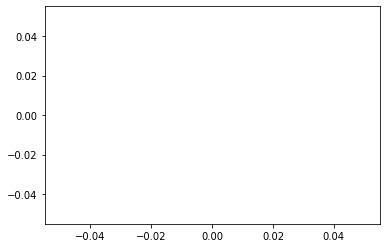

In [76]:
plt.plot(rmses)

In [77]:
#average rmses over time
print(np.mean(rmses))

#standard deviations of rmses
print(np.std(rmses))



nan
nan


In [78]:
stds=[]
for i in range(421):
    data=pco2.pCO2.data[i]
    stds.append(np.std(data[~np.isnan(data)]))
print(np.mean(stds))

40.12670890353768
